In [1]:
#%%imports
import glob
import importlib
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import os
import polars as pl
import re
import sys
from typing import Literal

sys.path.append("../")
from src_py import (
    utils as lvisu,
    makedata as md
)
from src_py.LVisPCanvas import LVisPCanvas
from src_py.LVisPPanel import LVisPPanel

# plt.style.use("dark_background")

# Get the Data

In [2]:
#%%data loading
#passbands
df_pb = pl.read_csv("../data/passband_specs.csv")
passbands = list(df_pb["name"])
pb_mappings = dict(zip(df_pb["wavelength"], df_pb.select(pl.exclude("wavelength")).to_numpy()))

#LCs
fnames = sorted(glob.glob("../data/*_*.csv"))
fnames = np.append(fnames, ["../data/lc_simulated.py", "../data/sin_simulated.py"])
print(fnames)
fname = fnames[-2]

#deal with on-the-fly data generation (pseudo filenames)
if fname == "../data/lc_simulated.py":
    raw, pro = md.simulate(5, opt="lc")
    df = pl.concat([pl.from_dict(raw), pl.from_dict(pro)])
    for t in df["period"].unique(): pb_mappings[t] = [np.round(t, 3)]
    legend = False
    thetalab = "Maximum Amplitude"
    xlab = "Time [d]"
    ylab = "Amplitude []"
elif fname == "../data/sin_simulated.py":
    raw, pro = md.simulate(5, opt="sin")
    df = pl.concat([pl.from_dict(raw), pl.from_dict(pro)])
    for t in df["period"].unique(): pb_mappings[t] = [np.round(t, 3)]
    legend = False
    thetalab = "Period [s]"
    xlab = "Time [s]"
    ylab = "Amplitude []"
else:
    df = pl.read_csv(fname, comment_prefix="#")
    df = df.sort(pl.col(df.columns[1]))
    legend = True
    thetalab = "Wavelength [nm]"
    xlab = "MJD-min(MJD) [d]" if "mjd" in df.columns else "Period [d]"
    ylab = "m [mag]" if "mag" in df.columns else "Fluxcal []"

# df = df.drop_nans()

# #sigma clipping
# df = df.filter(
#     pl.col(df.columns[2]).median()-3*pl.col(df.columns[2]).std() <= pl.col(df.columns[2]),
#     pl.col(df.columns[2]) <= pl.col(df.columns[2]).median()+3*pl.col(df.columns[2]).std(),
# )

# parts = re.split(r"[/\_\.]", fname)
# survey = parts[-2]
# otype = parts[-3]

df_raw = df.filter(pl.col("processing")=="raw")
df_pro = df.filter(pl.col("processing")!="raw")
theta_raw = np.sort(np.unique(df_raw[:,0]))
df_raw_p = df_raw.partition_by(df_raw.columns[0], maintain_order=True)
x_raw = [df[:,1].to_numpy().astype(np.float64) for df in df_raw_p]
x_raw = [xi - np.nanmin(xi) for xi in x_raw]
y_raw = [df[:,2].to_numpy().astype(np.float64) for df in df_raw_p]
theta_pro = np.sort(np.unique(df_pro[:,0]))
df_pro_p = df_pro.partition_by(df_pro.columns[0], maintain_order=True)
x_pro = [df[:,1].to_numpy().astype(np.float64) for df in df_pro_p]
x_pro = [xi - np.nanmin(xi) for xi in x_pro]
y_pro = [df[:,2].to_numpy().astype(np.float64) for df in df_pro_p]


['../data/00001_rrab_ogle.csv' '../data/00015_rrc_ogle.csv'
 '../data/0019_cepheid_elasticc.csv' '../data/0186_snib_elasticc.csv'
 '../data/02202_rrd_ogle.csv' '../data/0246_snic_elasticc.csv'
 '../data/0357_rrl_elasticc.csv' '../data/0901_snii_elasticc.csv'
 '../data/11370314_snib_des.csv' '../data/114645810_snibc_elasticc.csv'
 '../data/11500415_sniin_des.csv' '../data/1189_snia_elasticc.csv'
 '../data/120712717_snibc_elasticc.csv'
 '../data/122276966_snibc_elasticc.csv'
 '../data/124266324_snii_elasticc.csv'
 '../data/132358631_snii_elasticc.csv' '../data/13686088_snia_des.csv'
 '../data/1419_eb_elasticc.csv' '../data/15108182_snic_des.csv'
 '../data/18213902_sniip_des.csv' '../data/1853138_sniil2_des.csv'
 '../data/2025_tde_elasticc.csv' '../data/21794560_snib_des.csv'
 '../data/21951066_sniil2_des.csv' '../data/22502500_sniil1_des.csv'
 '../data/2723412_sniin_des.csv' '../data/28191381_sniil1_des.csv'
 '../data/29216742_sniil2_des.csv' '../data/29508760_snic_des.csv'
 '../data/303

In [3]:
#%%get stats
unique_thetas = np.unique(theta_raw)
thetaticks = np.round(np.linspace(np.floor(np.min(theta_raw)), np.ceil(np.max(theta_raw)), 4),0).astype(int)
xticks = np.round(np.linspace(np.floor(np.min(np.concat(x_raw))), np.ceil(np.max(np.concat(x_raw))), 4), decimals=0).astype(int)
yticks = np.round(np.linspace(np.floor(np.min(np.concat(y_raw))), np.ceil(np.max(np.concat(y_raw))), 4), decimals=0).astype(int)
# yticks = np.sort(np.append(yticks, [-10, 80]))
panelsize = np.pi/10
vmin = 300 if ".py" not in fname else None
colors = lvisu.get_colors(theta_raw, cmap="nipy_spectral", vmin=vmin)

# Standard Usage

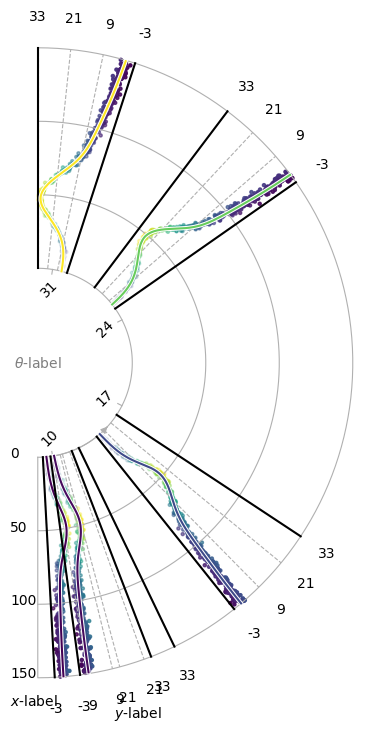

In [ ]:
fig = plt.figure(figsize=(5,9))
ax = fig.add_subplot(111)

#init canvas (similar to `plt.figure()`)
LVPC = LVisPCanvas(ax,
    thetaticks,
    xticks=xticks,                          #use as ticks and labels
    # xticks=[-20,0,20,100],                  #custom (also use as labels)
    # xticks=(xticks,["x1","x2","x3","x4"]),  #custom labels
    yticks=yticks,
    thetaguidelims=(-np.pi/2,np.pi/2), thetaplotlims=(-np.pi/2+panelsize/2,np.pi/2-panelsize/2),
    xlimdeadzone=0.3,
    thetalabel=r"$\theta$-label", xlabel=r"$x$-label", ylabel=r"$y$-label",
    thetaarrowpos_th=15, ylabpos_th=np.min(theta_raw),
    thetatickkwargs=dict(ls="-"), thetaticklabelkwargs=dict(rotation=45), thetalabelkwargs=dict(c="tab:grey"),
    xtickkwargs=dict(ls="-"), xticklabelkwargs=dict(xytext=(-2,0)), xlabelkwargs=dict(c="k"),
)

#get colors for colormapping `theta`
colors = lvisu.get_colors(theta_raw)

#plot different panels
for i in range(len(theta_raw)):
    
    #add a panel (similar to `ax = fig.add_subplot()`)
    LVPP = LVPC.add_panel(
        theta=theta_raw[i],
        yticks=None,                                                #as initialized in `LVisPCanvas`
        # yticks=yticks,                                              #predifined (use also as labels)
        # yticks=[np.floor(y_raw[i].min()), np.ceil(y_raw[i].max())], #data fills the entire panel
        # yticks=(yticks, ["A", "B", "C", "D"]),                      #predifined (custom labels)
        panelsize=panelsize,
        show_panelbounds=True, show_yticks=True,
        y_projection_method="theta",                                #execute projection in theta-space (preferred)
        # y_projection_method="y",                                    #execute projection in y-space
        ytickkwargs=dict(ls="--"), yticklabelkwargs=None,
        panelboundskwargs=None,
    )

    #plotting into the panel (similar to `ax.plot()`) 
    LVPP.scatter(x_raw[i], y_raw[i], c=y_raw[i], s=5,  alpha=np.linspace(0, 1, y_raw[i].shape[0]))
    LVPP.plot(x_pro[i], y_pro[i], c="w", lw=3)
    LVPP.plot(x_pro[i], y_pro[i], color=colors[i])

plt.show()

# Convenience Usage
